Problem Set 1a: Text classification using Naive Bayes
==============



In this problem set, we will build a system for classifying movie reviews as positive, negative, or neutral. You will:

- Do some basic text processing, tokenizing your input and converting it into a bag-of-words representation
- Build a classifier based on sentiment word lists
- Build a machine learning classifier, using Naive Bayes
- Evaluate your classifiers and examine what they have learned



## Installation ##

You may need to install some of the libraries below. Usually this is done with pip or easy_install. See here:

- [NLTK](http://www.nltk.org/install.html)
- [matplotlib](http://matplotlib.org/users/installing.html)
- [numpy](http://docs.scipy.org/doc/numpy/user/install.html)

In [1]:
from __future__ import division
from nltk.tokenize import word_tokenize, sent_tokenize
from collections import defaultdict, Counter
from matplotlib import pyplot as plt
import numpy as np
import scorer
import operator

# 1. Data Processing #
(_Completing docsToBOWs() - 4 pts, each question in Deliverable 1 is worth 1 pt. Total 8 pts for part 1_)

Your first step is to write code that can apply the following
preprocessing steps. You will have to run this code fairly quickly on
the test data when you receive it, so make sure it is modular and
well-written.

- You will edit a function that takes as its argument a "key" document.
  It should produce a "BOW" (bag-of-words) document.
  Each line of the key document contains a filename and a label.
  Each line of the BOW document should contain a BOW representation of the corresponding
  file in the key document. 
- A BOW representation looks like this: "word:count word:count word:count..." for every word that appears in
  the document. Do not print words that have zero count. Use space delimiters.
- Use NLTK's [tokenization package](http://nltk.org/api/nltk.tokenize.html) function 
  to divide each file into sentences, and each sentence into tokens.
- Downcase all tokens
- Only consider tokens that are completely alphabetic.

I have provided some shell code, but you will have to fill in the tokenization and filtering steps.

In [2]:
def docsToBOWs(keyfile):
    with open(keyfile,'r') as keys:
        with open(keyfile.replace('.key','.bow'),'w') as outfile:
            for keyline in keys:
                dataloc = keyline.rstrip().split(' ')[0]
                fcounts = dict()
                with open(dataloc,'r') as infile:
                    for line in infile: 
                        l = line.decode('ascii', 'ignore')
                        token_sent = sent_tokenize(l)
                        for s in token_sent:
                            token_word = word_tokenize(s)
                            for w in token_word:
                                if w.isalpha():
                                    w = w.lower()
                                    if fcounts.has_key(w):
                                        fcounts[w] += 1
                                    else:
                                        fcounts[w] = 1
                for word,count in fcounts.items():
                    print >>outfile,"{}:{}".format(word,count), #write the word and its count to a line
                print >>outfile,""

These are the keyfiles that are relevant to this homework. 
At the beginning you won't have test-imdb.key

In [3]:
trainkey = 'train-imdb.key'
devkey = 'dev-imdb.key'
testkey = 'test-imdb.key'

Next, run these lines to produce the BOW files.

In [4]:
docsToBOWs(trainkey)
docsToBOWs(devkey)
# docsToBOWs('test-imdb.key') # you won't have this file yet

The next cell defines a [generator function](http://wiki.python.org/moin/Generators), called "dataIterator"

- This allows you to easily iterate through the dataset defined by a given keyfile. 
- Each time you call "next" (possibly implicitly), it returns a dict containing features and counts for the next document in the sequence. 
- In this case, the features include the words, and a special "offset" feature
- This is equivalent to $\boldsymbol{x}_i$ in the reading.
- You can see how this is used in the getAllCounts() function below, which takes a dataIterator as an argument.

Lines 7-8 of the code might look confusing if you are not a pythonista. 

- This is a [list comprehension](http://legacy.python.org/dev/peps/pep-0202/)
nested inside a [dict comprehension](http://legacy.python.org/dev/peps/pep-0274/).
- Here's an [introduction](http://carlgroner.me/Python/2011/11/09/An-Introduction-to-List-Comprehensions-in-Python.html) with more examples.

In [5]:
offset = '**OFFSET**'
def dataIterator(keyfile):
    with open(keyfile.replace('key','bow'),'r') as bows:
        with open(keyfile,'r') as keys:
            for keyline in keys:
                textloc,label = keyline.rstrip().split(' ')
                fcounts = {word:int(count) for word,count in\
                           [x.split(':') for x in bows.readline().rstrip().split(' ')]}
                fcounts[offset] = 1
                yield fcounts,label

The dataIterator above incrementally re-reads the keyfile and BOW file every time you call it. 
This is a good idea if you have huge data that won't fit in memory, but the file I/O involves some overhead.
If you want, you can write a second dataIterator that iterates across data stored in memory, which
will be faster.

**Sanity check**: How many unique words appear in the training set? (Types, not tokens.) I get 24861. (Don't count the offset feature.)

- Note how the dataIterator function is used here. 
- fcounts is a dict, which it returns for each document.
- We are currently ignoring the label, but that is also provided.
- This may take a couple of minutes to run

In [6]:
def getAllCounts(datait):
    allcounts = Counter()
    for fcounts, _ in datait:
        allcounts += Counter(fcounts)
    return allcounts

ac_train = getAllCounts(dataIterator('train-imdb.key'))
ac_dev = getAllCounts(dataIterator('dev-imdb.key'))
print "Number of word types in training set: ",len(ac_train.keys())-1
print "Number of tokens in training set: ",sum(ac_train.values())-1
print "Number of word types in dev set: ",len(ac_dev.keys())-1
print "Number of tokens in dev set: ",sum(ac_dev.values())-1
print "Token to type ratio for training set: ", (sum(ac_train.values())-1) / (len(ac_train.keys())-1) 
print "Token to type ratio for dev set: ", (sum(ac_dev.values())-1) / (len(ac_dev.keys())-1) 
print "Words which appear in dev data but not in training data: ", len(set(ac_dev.keys()) - set(ac_train.keys()))
print "Number of words which exactly once in training data: ", len([item for item in ac_train.values() if item==1])
print "Number of words which exactly once in dev data: ", len([item for item in ac_dev.values() if item==1])

Number of word types in training set:  24999
Number of tokens in training set:  466683
Number of word types in dev set:  16965
Number of tokens in dev set:  223994
Token to type ratio for training set:  18.6680667227
Token to type ratio for dev set:  13.2033009136
Words which appear in dev data but not in training data:  4843
Number of words which exactly once in training data:  10910
Number of words which exactly once in dev data:  8064


The following code makes a plot, with the log-rank (from 1 to the log of the total number of words) 
on the x-axis and the log count on the y-axis.

In [7]:
# this enables you to create inline plots in the notebook 
%pylab inline

Populating the interactive namespace from numpy and matplotlib


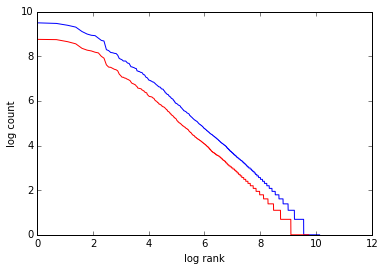

In [8]:
tr_logcounts = np.log(np.array(sorted(ac_train.values(),reverse=True)))
plt.plot(np.log(range(len(tr_logcounts))),tr_logcounts)
dv_logcounts = np.log(np.array(sorted(ac_dev.values(),reverse=True)))
plt.plot(np.log(range(len(dv_logcounts))),dv_logcounts,'r')
plt.xlabel('log rank')
plt.ylabel('log count')

**Deliverable 1**

- Explain what you see in the plot. Does it observe Zipf's law? How well?
- Print the token/type ratio for both the training and dev data.
- Print the number of types which appear exactly once in the training and dev data
- Print the number of types that appear in the dev data but not the training data (hint: use [sets](https://docs.python.org/2/library/sets.html) for this)

# 2. Word Lists #
(_Completing predict() - 3 pts, setting weights - 2 pts, Deliverable 2 - 1 pt. Total 7 pts for part 2_)

- We will now build a sentiment analysis system based on word lists. 
- The file "sentiment-vocab.tff" contains a sentiment lexicon from [ Wilson et al 2005](http://people.cs.pitt.edu/~wiebe/pubs/papers/emnlp05polarity.pdf). 
- The code below reads the lexicon into memory, building sets of positive and negative words.

In [9]:
poswords = set()
negwords = set()
with open('sentiment-vocab.tff','r') as fin:
    for i,line in enumerate(fin):
        # more list and dict comprehensions!
        kvs = {key:val for key,val in [kvp.split('=') for kvp in line.split() if '=' in kvp]}
        if kvs['type'] == 'strongsubj':
            if kvs['priorpolarity'] == 'negative':
                negwords.add(kvs['word1'])
            if kvs['priorpolarity'] == 'positive':
                poswords.add(kvs['word1'])

Next, you should write a classifier that classifies each instance in a testfile. The classification rule is:

- 'POS' if the instance has more words from the positive list than the negative list
- 'NEG' if the instance has more words from the negative list than the positive list
- 'NEU' (neutral) if the instance has the same number of words from each list

To do this, you will write a function "predict", 
which represents the inner-product computation $\boldsymbol{\theta}' \boldsymbol{f}(\boldsymbol{x},y)$.
It should have the following characteristics:

- **Input 1** an instance, represented as a dict (with features as keys and counts as values) 
- **Input 2** a dictionary of weights, where keys are tuples of features and labels, and weights are the values. This corresponds to $\boldsymbol{\theta}$ in the reading. See example below.
- **Input 3** a list of possible labels
- **Output 1** the highest-scoring label
- **Output 2** a dict with labels as keys and scores as values

In [10]:
# use this to find the highest-scoring label
argmax = lambda x : max(x.iteritems(),key=operator.itemgetter(1))[0]

In [11]:
def predict(instance,weights,labels):
    scores = defaultdict(int)
    for w , count in instance.items():
        for label in labels:
            scores[label] = scores.get(label,0) + count*weights.get((label,w),0)
    return argmax(scores),scores
    # return the highest-scoring label, and the scores for all labels

Here are weights for the simplest classifier, which simply labels all instances as positive.

Note that it uses only the 'offset' feature

In [12]:
all_labels = ['POS','NEG','NEU']
weights_all_pos = defaultdict(int)
weights_all_pos.update({('POS',offset):1,('NEG',offset):0,('NEU',offset):0})

Here is some code for evaluating your classifiers. 
It uses a scoring library that I wrote, and writes the output to a file.

In [13]:
def evalClassifier(weights,outfilename,testfile=devkey):    
    with open(outfilename,'w') as outfile: #open the output file
        for counts,label in dataIterator(testfile): #iterate through eval set
            print >>outfile, predict(counts,weights,all_labels)[0] #print prediction to file
    return scorer.getConfusion(testfile,outfilename) #run the scorer on the prediction file

The code below shows how to evaluate this classifier. 

- **Sanity check**: You should get 40.7% accuracy just by classifying everything as positive. This is the "most common class" (MCC) baseline.

The printed output is a **confusion matrix**. 
The rows indicate the key and the columns indicate the response. 
In this case, the response is always "POS", so there is only one column. 
The cell NEG/POS tells you how often an example that was labeled "NEG" in the key was labeled "POS" in the system response.

In [14]:
mat = evalClassifier(weights_all_pos,'all_pos.txt')
print scorer.printScoreMessage(mat)

3 classes in key: set(['NEG', 'NEU', 'POS'])
1 classes in response: set(['POS'])
confusion matrix
key\response:	POS
NEG		401	
NEU		192	
POS		407	
----------------
accuracy: 0.4070 = 407/1000

None


Now build a classifier based on the word lists. The classifier should have the following decision rule:

- If the number of positive words (tokens) is greater than the number of negative words, choose label 'POS'
- If the number of negative words (tokens) is greater than the number of positive words, choose label 'NEG'
- If they are equal, choose label 'NEU'

You should manually set the weights to ensure this behavior; don't change the predict function at all.
You'll need to use the offset weights to make sure that ties go to the 'NEU' label.

In [15]:
weights_list = defaultdict(int)
for item in poswords:
    weights_list.update({('POS',item): 3})
for item in negwords:
    weights_list.update({('NEG',item): 3})
weights_list.update({('NEU',offset):  9})

**Deliverable 2**: run your classifier on dev.key, and use the following code to print the resulting confusion matrix.

The confusion matrix should now have three columns, since the response should include every class at least once. The count of correct responses is found on the diagonal of the confusion matrix. What is the most frequent type of error?

**Sanity check**: The accuracy should be 55.9%

In [16]:
mat = evalClassifier(weights_list,'word_list.txt')
print scorer.printScoreMessage(mat)

3 classes in key: set(['NEG', 'NEU', 'POS'])
3 classes in response: set(['NEG', 'NEU', 'POS'])
confusion matrix
key\response:	NEG	NEU	POS
NEG		220	17	164	
NEU		61	17	114	
POS		51	36	320	
----------------
accuracy: 0.5570 = 557/1000

None


# 3. Naive Bayes #
(_Completing learnNBWeights() - 5 pts, Deliverable 3a - 1pt, 3b - 1 pt, explanation of plot output - 2pts. Total 8 points for part 3_)

Now you will implement a Naive Bayes classifier.

You already have the code for the decision function, "predict". 
So you just need to construct a set of weights that correspond to the classifier. 
These weights will contain two parameters:

- $\log \mu$ for the offset, which parametrizes the prior $\log P(y)$
- $\log \phi$ for the word counts, which parametrizes the likelihood $\log P(x | y)$

You should use maximum *a posteriori* estimation of
the parameter $\phi$,
$$\phi_{j,n} = P(w = n | y = j) = \frac{\sum_{i: y_i = j} x_{i,n} + \alpha}{\sum_{i:y_i=j} \sum_{n'} x_{i,n'} + V\alpha}$$
where 

- $y_i = j$ indicates the class label $j$ for instance $i$
- $w=n$ indicates word $n$
- $\alpha$ is the smoothing parameter
- $V$ is the total number of words

For each class, normalize by the sum of counts of words **in that class**. In other words, $\sum_j \phi_{j,n} = 1$ for all $j$. You can estimate $\log \phi$ directly if you prefer.

For the prior $\log P(y)$, you can use relative frequency estimation.

Both probabilities should be estimated from the training data only.
Please write this code yourself -- do not use other libraries, and try to do
it without looking at other code online.

In [17]:
from itertools import chain #hint, especially if you're obsessive about being pythonic

In [18]:
# compute the word counts first, because this can be slow
# you may also wish to keep a list of all word types that are observed in the training data
counts = defaultdict(lambda : Counter()) # hint
class_counts = defaultdict(int) # hint

def getCounts_all(datait):
    pos_counts = Counter()
    neg_counts = Counter()
    neu_counts = Counter()
    global neg_docCount,pos_docCount, neu_docCount
    neg_docCount = 0 
    pos_docCount = 0
    neu_docCount = 0
    
    for fcounts, label in datait:
        if label == 'POS':
            pos_counts += Counter(fcounts)
            pos_docCount += 1
        elif label == 'NEG':
            neg_counts += Counter(fcounts)
            neg_docCount += 1
        elif label == 'NEU':
            neu_counts += Counter(fcounts)
            neu_docCount += 1
    return pos_counts,neg_counts,neu_counts

pos_train,neg_train,neu_train  = getCounts_all(dataIterator('train-imdb.key'))

pos_sum = sum(pos_train.values())
neg_sum = sum(neg_train.values())
neu_sum = sum(neu_train.values())

total_words = len(ac_train.keys())-1
total_docCount  = pos_docCount + neg_docCount + neu_docCount

You should write a *function* to compute the weights for a given value of $\alpha$, 
because you will want to vary this value later.

In [19]:
def learnNBWeights(alpha=0.1):
    weights =  defaultdict(float)# your code here
    bayes_numerator = float()
    bayes_denominator = float()
    log_phi = float()
    
    for word in pos_train:
        bayes_numerator = pos_train[word] + alpha
        bayes_denominator = pos_sum + total_words*alpha
        log_phi = np.log(bayes_numerator) - np.log(bayes_denominator)
        weights.update({('POS',word): log_phi})
        
    for word in neg_train:
        bayes_numerator = neg_train[word] + alpha
        bayes_denominator = neg_sum + total_words*alpha
        log_phi = np.log(bayes_numerator) - np.log(bayes_denominator)
        weights.update({('NEG',word): log_phi})
        
    for word in neu_train:
        bayes_numerator = neu_train[word] + alpha
        bayes_denominator = neu_sum + total_words*alpha
        log_phi = np.log(bayes_numerator) - np.log(bayes_denominator)
        weights.update({('NEU',word): log_phi})
    
    weights.update({('POS',offset): (np.log(pos_docCount)- np.log(total_docCount))})
    weights.update({('NEG',offset): (np.log(neg_docCount)- np.log(total_docCount))})
    weights.update({('NEU',offset): (np.log(neu_docCount)- np.log(total_docCount))})  
    return weights

    

**Deliverable 3a**
Train a classifier from the training data, and apply it to
the development data, with $\alpha = 0.1$. Report the confusion matrix and the accuracy.

In [20]:
# compute the weights
weights_nb = learnNBWeights(alpha=0.1)

**Sanity check**: For the following instance, I get the scores shown.

In [21]:
predict({'good':1,'worst':4,offset:1},weights_nb,all_labels)

('NEG',
 defaultdict(<type 'int'>, {'NEG': -34.774652009636632, 'NEU': -40.685465798167527, 'POS': -44.324484194528054}))

In [22]:
# run this code to evaluate your weights
mat = evalClassifier(weights_nb,'nb.txt')
print scorer.printScoreMessage(mat)

3 classes in key: set(['NEG', 'NEU', 'POS'])
3 classes in response: set(['NEG', 'NEU', 'POS'])
confusion matrix
key\response:	NEG	NEU	POS
NEG		101	268	32	
NEU		40	140	12	
POS		111	264	32	
----------------
accuracy: 0.2730 = 273/1000

None


**Deliverable 3b** Try at least seven different values of $\alpha$. Plot the accuracy on both the dev and training sets for each value, using [subplot](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.subplot) to show two plots in the same cell.

In [23]:
tr_accs = []
dv_accs = []
alphas = [0.1,0.5,0.9,1,4,9,18,69,100,1000]
weights_nb_alphas = dict()
for alpha in alphas:
    print alpha,
    # learn the weights
    weights_nb_alphas[alpha] = learnNBWeights(alpha) 
    # evaluate on training data
    confusion = evalClassifier(weights_nb_alphas[alpha],'nb.alpha.tr.txt',trainkey)
    tr_accs.append(scorer.accuracy(confusion))
    # evaluate on dev data
    confusion = evalClassifier(weights_nb_alphas[alpha],'nb.alpha.dv.txt',devkey)
    dv_accs.append(scorer.accuracy(confusion))
    print dv_accs[-1]

0.1 0.273
0.5 0.288
0.9 0.286
1 0.291
4 0.338
9 0.347
18 0.329
69 0.305
100 0.3
1000 0.26


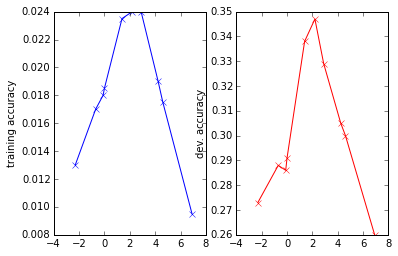

In [24]:
# run this code to plot the accuracies
subplot(1,2,1)
plot(log(alphas),tr_accs,'bx-')
ylabel('training accuracy')
subplot(1,2,2)
plot(log(alphas),dv_accs,'rx-')
ylabel('dev. accuracy')

# 4. Feature Analysis #

(_Completing  getTopFeats() - 2 pts, Deliverable 4a - 1pt, 4b - 2 pts, 4c - 2 pts, 4d -5pts . Total 7 pts for CS4650 and 12 pts for CS7650_)


**Deliverable 4a**
What are the words that are most predictive of positive versus negative text?
You can measure this by $\log \theta_{pos,n} - \log \theta_{neg,n}$ (which is similar to the [likelihood ratio test](http://en.wikipedia.org/wiki/Likelihood-ratio_test)).
Use $\alpha = 1$ from the dev data.

List the top five words and their counts for each class. Do the same for the top 5 words that predict negative versus positive.

Consider using [operator.itemgetter()](http://docs.python.org/2.7/library/operator.html) for easily sorting dictionaries by their values. See my definition of the argmax function above.

In [25]:
def getTopFeats(weights,class1,class2,K=5):
    class1_Dict = defaultdict(float)
    class2_Dict = defaultdict(float)
    class_Ratio = defaultdict(float)
    for word,value in weights.iteritems():
        if word[0] == class1:
            class1_Dict[word[1]] = value
        elif word[0] == class2:
            class2_Dict[word[1]] = value
    intersect = set(class1_Dict.keys()).intersection(set(class2_Dict.keys()))
    for word in intersect:
        class_Ratio[word] = class1_Dict[word] - class2_Dict[word]
    sorted_list = sorted(class_Ratio.iteritems(), key=operator.itemgetter(1), reverse = True)
    count_list = [ (k[0],( pos_train[k[0]],  neg_train[k[0]],  neu_train[k[0]])) for k in sorted_list[:K]]
    return count_list
  

In [26]:
# run this
print "Following format is used: (word,(Positive_wordCount, Negative_wordCount, Neutral_wordCount))"
print getTopFeats(weights_nb_alphas[1],'POS','NEG')
print getTopFeats(weights_nb_alphas[1],'NEG','POS')

Following format is used: (word,(Positive_wordCount, Negative_wordCount, Neutral_wordCount))
[('subtle', (30, 1, 5)), ('emotions', (26, 1, 9)), ('themes', (26, 1, 8)), ('homer', (26, 1, 0)), ('victor', (19, 1, 4))]
[('awful', (4, 103, 19)), ('redeeming', (1, 26, 1)), ('lance', (1, 24, 0)), ('hulk', (1, 23, 0)), ('waste', (7, 82, 8))]


**Deliverable 4b** Now do the same thing for $\alpha = 100$. Which words look better to you? 
Which gave better accuracy? 
Explain what you think is going on.

In [27]:
# run this
print "Following format is used: (word,(Positive_wordCount, Negative_wordCount, Neutral_wordCount))"
print getTopFeats(weights_nb_alphas[100],'POS','NEG')
print getTopFeats(weights_nb_alphas[100],'NEG','POS')

Following format is used: (word,(Positive_wordCount, Negative_wordCount, Neutral_wordCount))
[('great', (457, 133, 164)), ('best', (311, 107, 85)), ('excellent', (114, 19, 27)), ('wonderful', (100, 13, 15)), ('love', (284, 123, 71))]
[('bad', (127, 496, 130)), ('worst', (17, 169, 25)), ('awful', (4, 103, 19)), ('worse', (17, 111, 15)), ('waste', (7, 82, 8))]


**Deliverable 4c** Consider the weights for $\alpha=100$. 

- Print words $w$ that are in the positive lexicon, but for which $\log \phi_{neg,w} > \log \phi_{pos,w} + 0.1$. 
    - (These words are more likely in the negative class, despite being in the positive lexicon.)
- Print words $w$ that are in the negative lexicon, but for which the $\log \phi_{pos,w} > \log \phi_{neg,w} + 0.1$. 
    - (These words are more likely in the positive class, despite being in the negative lexicon.)


In [29]:
pos_list = []
neg_list = []
for word in poswords:
    if weights_nb_alphas[100].has_key(('NEG',word)) and (weights_nb_alphas[100][('NEG',word)] - weights_nb_alphas[100][('POS',word)]) > 0.1:
        pos_list.append(word)
for word in negwords:
    if weights_nb_alphas[100].has_key(('POS',word)) and (weights_nb_alphas[100][('POS',word)] - weights_nb_alphas[100][('NEG',word)]) > 0.1:
        neg_list.append(word)
        
print "Words which despite being in positive lexicon are classified negative: " 
print pos_list
print "Words which despite being in negative lexicon are classified positive: " 
print neg_list

Words which despite being in positive lexicon are classified negative: 
['compassion', 'ovation', 'delightfully', 'veritable', 'elegant', 'crave', 'valiant', 'liberty', 'feisty', 'romantically', 'joyous', 'want', 'unforgettable', 'preferably', 'preferable', 'dignified', 'astoundingly', 'devote', 'admirably', 'better', 'entranced', 'herald', 'sparkle', 'aspire', 'angelic', 'playfully', 'encouraging', 'thoughtfully', 'insightful', 'congratulatory', 'fabulous', 'enchanted', 'wholesome', 'exonerate', 'endear', 'marvelously', 'quaint', 'gutsy', 'foremost', 'relish', 'monumental', 'stunningly', 'pacifist', 'fragrant', 'sensitivity', 'humankind', 'tolerance', 'idyllic', 'exemplary', 'majestic', 'gratitude', 'privilege', 'idol', 'shimmering', 'admiration', 'delight', 'renaissance', 'groundbreaking', 'stupendous', 'just', 'zeal', 'splendor', 'revel', 'superlative', 'delighted', 'unpretentious', 'overjoyed', 'vitality', 'congratulations', 'incisive', 'soothe', 'excel', 'trepidation', 'intimacy',

Food for Thought: 

What do you think is going on here? Pick one of these words, and look for example reviews that contain it (using [grep](http://en.wikipedia.org/wiki/Grep)). 

Is the word used in the opposite sense, or is there some other explanation?